In [6]:
import sys 
import os
import numpy as np
import itertools
from dataclasses import dataclass, replace, field
from matplotlib import pyplot as plt
from typing import Optional, Mapping, Dict, Tuple, TypeVar, Iterable, Sequence, Callable, Iterator, List
from scipy.stats import norm

from rl.markov_process import MarkovProcess, NonTerminal, State
from rl.distribution import Gamma, Distribution, Constant

from rl.chapter9.order_book import OrderBook, DollarsAndShares, PriceSizePairs

In [18]:
class OrderBookSimulator(MarkovProcess[OrderBook]):


    '''
    This class will model an order book as a Markov process, so we must implement the abstract method
    transition. In order to do that, we must specify the probability model with which those transitions
    depend. First, at each time step, we will use a RNG to determine which kind of order we will process.
    Note, we will not handle multiple orders at a given time step, but this shouldn't matter as we make
    the resolution (magnitude of time step) finer and finer. Next, depending on which kind of order it is
    (Market or Limit) we will again use a RNG (with different distributions) to determine the next state.
    If it's a market order, we just need to define a distribution that gives us the # of shares this order
    wants. We'll use a gamma distribution with user-defined parameters to model this share count. In order
    to model a Limit Order, we can use this gamma distribution for # of shares, but we must add an additional
    distribution to model the price. For the price, we'll use another single gamma distribution to model the
    distance "away" from the mid price that the limit order is set at. Thus, depending if its a sell LO or
    buy LO, we can +/- the sampled value to get this price. 
    '''

    order_types: List[str] = ["SellLO", "BuyLO", "SellMO", "BuyMO"]
    share_alpha: float
    share_beta: float
    price_alpha: float
    price_beta: float
        
    def __init__(self, share_alpha, share_beta, price_alpha, price_beta):
        self.share_alpha = share_alpha
        self.share_beta = share_beta
        self.price_alpha = price_alpha
        self.price_beta = price_beta
        super().__init__()
    
        
        
    def transition(self, state: NonTerminal[OrderBook]) -> Distribution[State[OrderBook]]:
        idx = np.random.randint(0,len(self.order_types))
        order_type = self.order_types[idx]
        
        
        shares = int(np.random.gamma(self.share_alpha, 1/self.share_beta))
        del_price = np.random.gamma(self.price_alpha, 1/self.price_beta)
        
        
        if len(state.state.ascending_asks) == 0:
            #No more asks, need to poplulate that side of order book
            price = round(state.state.descending_bids[0].dollars + del_price,2)
            _ , new_order_book = state.state.sell_limit_order(price,shares)
            return Constant(NonTerminal(new_order_book))
        
        if len(state.state.descending_bids) == 0:
            #No more bids, need to populate that side of order book
            price = round(state.state.ascending_asks[0].dollars - del_price,2)
            _ , new_order_book = state.state.buy_limit_order(price,shares)
            return Constant(NonTerminal(new_order_book))            

        
        #print(shares, del_price)
        
        
        if order_type == "SellLO":
            price = round(state.state.mid_price() + del_price)
            _ , new_order_book = state.state.sell_limit_order(price,shares)
            return Constant(NonTerminal(new_order_book))
        
            
        if order_type == "SellMO":
            _ , new_order_book = state.state.sell_market_order(shares)
            return Constant(NonTerminal(new_order_book))
            
        
        if order_type == "BuyLO":
            price = round(state.state.mid_price() - del_price)
            _ , new_order_book = state.state.buy_limit_order(price,shares)
            return Constant(NonTerminal(new_order_book))
        
            
        if order_type == "BuyMO":
            _ , new_order_book = state.state.buy_market_order(shares)
            return Constant(NonTerminal(new_order_book))
    






In [19]:
#Initialize an OrderBook


bids: PriceSizePairs = [DollarsAndShares(
        dollars = x,
        shares = np.random.poisson(100. - (100-x)*10)
        ) for x in range(100,90,-1)]
    
asks: PriceSizePairs = [DollarsAndShares(
        dollars = x,
        shares = np.random.poisson(100 - (105-x)*10)
        ) for x in range(105, 115, 1)]

book: OrderBook = OrderBook(descending_bids = bids, ascending_asks = asks)

start_state_distribution = Constant(NonTerminal(book))

OrderBookMP = OrderBookSimulator(share_alpha = 20, share_beta = 1, price_alpha = 4, price_beta = 2)

In [20]:
#Now let's run it
def order_book_traces(time_steps: int, num_traces: int) -> np.ndarray:
    return np.vstack([
        np.fromiter((s.state.mid_price() for s in itertools.islice(
        OrderBookMP.simulate(start_state_distribution),
        time_steps
        )), float) for _ in range(num_traces)
    ])



def oneTrace(time_steps: int):
    MidPrices = list()
    BidPrices = list()
    AskPrices = list()
    Bid_Ask_Spread = list()
    Market_Depth = list()
    Snapshot = 0
    for s in itertools.islice(OrderBookMP.simulate(start_state_distribution), time_steps):
        if s.state.descending_bids and s.state.ascending_asks:
            MidPrices.append(s.state.mid_price())
            BidPrices.append(s.state.bid_price())
            AskPrices.append(s.state.ask_price())
            Bid_Ask_Spread.append(s.state.bid_ask_spread())
            Market_Depth.append(s.state.market_depth())
        Snapshot = s.state
    return MidPrices, BidPrices, AskPrices, Bid_Ask_Spread, Market_Depth, Snapshot

In [28]:
#prices = order_book_traces(100, 25)
mid, bid, ask, spread, depth, snap = oneTrace(10000)

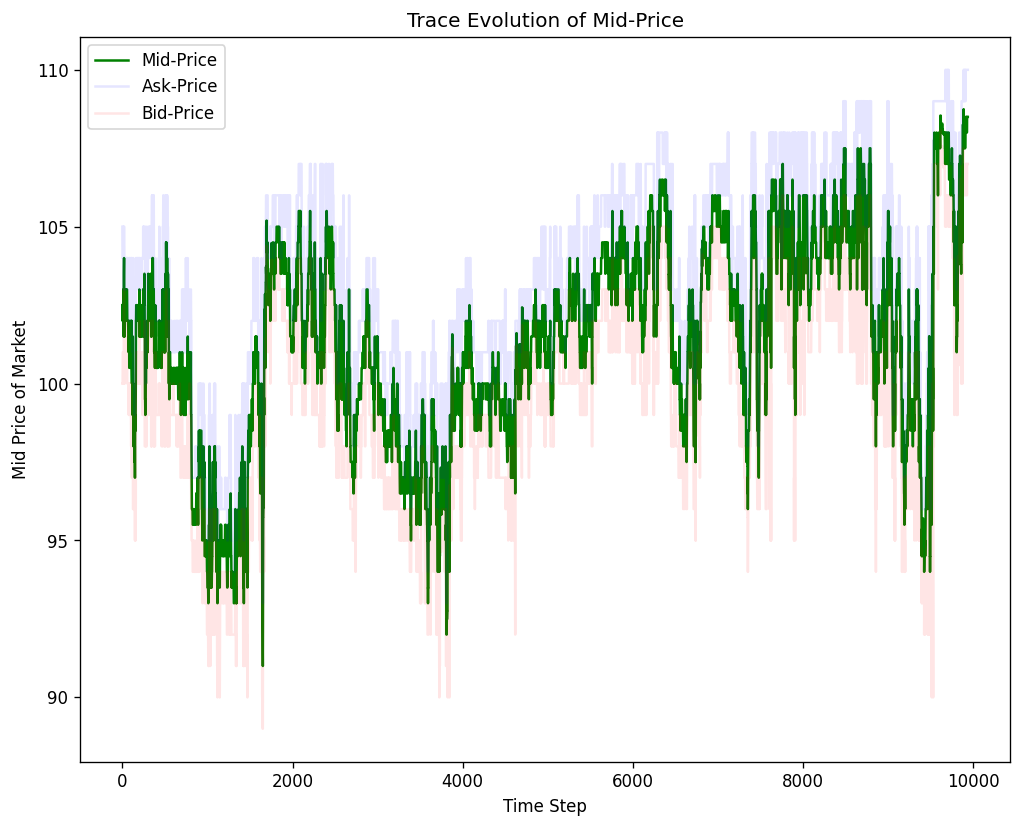

In [29]:
'''
err = np.zeros((2,len(mid)))
for idx, (b, a, m) in enumerate(zip(bid, ask, mid)):
    err[:, idx] = [abs(b-m),a-m] 

print(err)

plt.errorbar(t, mid, yerr = err, ecolor = "g", elinewidth=1, capsize = 5)
'''

plt.plot(mid, "g", label = "Mid-Price")
plt.plot(ask, "b", label = "Ask-Price", alpha = 0.1)
plt.plot(bid, "r", label = "Bid-Price", alpha = 0.1)
plt.title("Trace Evolution of Mid-Price")
plt.xlabel("Time Step")
plt.ylabel("Mid Price of Market")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10,8)
fig.set_dpi(120)

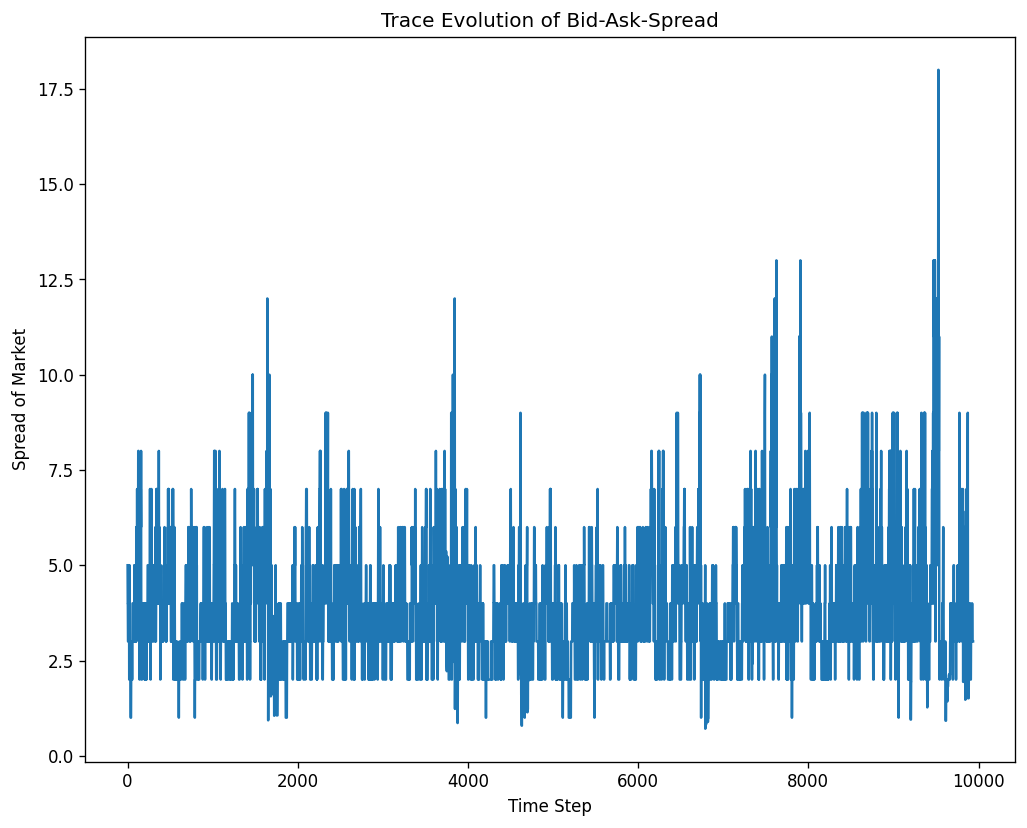

In [30]:
plt.plot(spread)
plt.title("Trace Evolution of Bid-Ask-Spread")
plt.xlabel("Time Step")
plt.ylabel("Spread of Market")
fig = plt.gcf()
fig.set_size_inches(10,8)
fig.set_dpi(120)

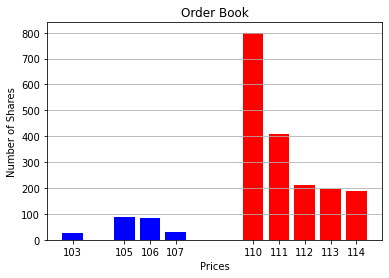

In [31]:
#Let's also take a quick peek at a screenshot of the last state of the order book
snap.display_order_book()

In [27]:
def order_book_traces(time_steps: int, num_traces: int, orderbook: OrderBookMP) -> np.ndarray:
    return np.vstack([
        np.fromiter((s.state.mid_price() for s in itertools.islice(
        orderbook.simulate(start_state_distribution),
        time_steps
        ) if (len(s.state.descending_bids) != 0 and len(s.state.ascending_asks) != 0)
        ), float) for _ in range(num_traces)
    ])



#Now, in order to see the effect of different parameters, we're going to average over last midprices 

plt.rcParams['text.usetex'] = False


OrderBookMP1 = OrderBookSimulator(share_alpha = 50, share_beta = 1, price_alpha = 4, price_beta = 2)
OrderBookMP2 = OrderBookSimulator(share_alpha = 20, share_beta = 1, price_alpha = 8, price_beta = 2)
OrderBookMP3 = OrderBookSimulator(share_alpha = 50, share_beta = 2.5, price_alpha = 4, price_beta = 2)
OrderBookMP4 = OrderBookSimulator(share_alpha = 25, share_beta = 2.5, price_alpha = 4, price_beta = 1)

orderbooks = [OrderBookMP,OrderBookMP1, OrderBookMP2, OrderBookMP3, OrderBookMP4]

time_steps = 50
average = np.zeros((5,time_steps))

for idx, ob in enumerate(orderbooks):
    midprices = order_book_traces(time_steps, 100, ob)
    
    titlestring = "alpha_{S}: " + str(ob.share_alpha) + "  beta_{S}: " + str(ob.share_beta)
    titlestring += "  alpha_{P}: " + str(ob.price_alpha) + "  beta_{P}: " + str(ob.price_beta)
    
    #Now get average midprice's
    average[idx, :] = np.mean(midprices, axis = 0)
    plt.plot(average[idx], alpha = 0.5, label = titlestring)
    
    #plt.hist(midprices[:,-1], alpha = 0.3, label = titlestring, bins = 50)
plt.title("Average Mid-Price in T")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10,8)
fig.set_dpi(120)



SyntaxError: invalid syntax (<ipython-input-27-57ce79b390ed>, line 6)

In [50]:
'''
Now we'll work on part B for the second problem, i.e. implementing the LPT model by customizing the class
Optimal Order Execution. We also need to create our own exponential Gaussian distribution
'''
from dataclasses import dataclass
from typing import Callable, Sequence, Tuple, Iterator
from rl.distribution import Distribution, SampledDistribution, Choose
from rl.function_approx import FunctionApprox, LinearFunctionApprox
from rl.markov_decision_process import MarkovDecisionProcess, \
    NonTerminal, State
from rl.policy import DeterministicPolicy
from rl.approximate_dynamic_programming import back_opt_vf_and_policy, \
    ValueFunctionApprox



@dataclass(frozen=True)
class PriceAndSharesAndMarket:
    price: float
    shares: int
    market: float
        
    

@dataclass(frozen=True)
class OptimalOrderExecutionExtended:
    
    shares: int
    time_steps: int
    avg_exec_price_diff: Sequence[Callable[[PriceAndSharesAndMarket], float]]
    price_dynamics: Sequence[Callable[[PriceAndSharesAndMarket], Distribution[float]]]
    X_dynamics: Sequence[Callable[[PriceAndSharesAndMarket], Distribution[float]]]
    utility_func: Callable[[float], float]
    discount_factor: float
    func_approx: ValueFunctionApprox[PriceAndSharesAndMarket]
    initial_price_distribution: Distribution[float]
    market: float

    def get_mdp(self, t: int) -> MarkovDecisionProcess[PriceAndSharesAndMarket, int]:
        """
        State is (Price P_t, Remaining Shares R_t, X_t)
        Action is shares sold N_t
        """

        utility_f: Callable[[float], float] = self.utility_func
        price_diff: Sequence[Callable[[PriceAndSharesAndMarket], float]] = \
            self.avg_exec_price_diff
        dynamics: Sequence[Callable[[PriceAndSharesAndMarket], Distribution[float]]] = \
            self.price_dynamics
        X_dynamics: Sequence[Callable[[PriceAndSharesAndMarket], Distribution[float]]] = \
            self.X_dynamics
        steps: int = self.time_steps

        class OptimalExecutionMDP(MarkovDecisionProcess[PriceAndSharesAndMarket, int]):

            def step(
                self,
                p_r: NonTerminal[PriceAndSharesAndMarket],
                sell: int
            ) -> SampledDistribution[Tuple[State[PriceAndSharesAndMarket],
                                           float]]:

                def sr_sampler_func(
                    p_r=p_r,
                    sell=sell,
                ) -> Tuple[State[PriceAndSharesAndMarket], float]:
                    p_s: PriceAndSharesAndMarket = PriceAndSharesAndMarket(
                        price=p_r.state.price,
                        shares=sell,
                        market = p_r.state.market
                    )
                    next_price: float = dynamics[t](p_s).sample()
                    next_rem: int = p_r.state.shares - sell
                    next_x: float = X_dynamics[t](p_s).sample()
                    next_state: PriceAndShares = PriceAndSharesAndMarket(
                        price=next_price,
                        shares=next_rem,
                        market = next_x
                    )
                    reward: float = utility_f(
                        sell * (p_r.state.price - price_diff[t](p_s))
                    )
                    return (NonTerminal(next_state), reward)

                return SampledDistribution(
                    sampler=sr_sampler_func,
                    expectation_samples=100
                )

            def actions(self, p_s: NonTerminal[PriceAndSharesAndMarket]) -> \
                    Iterator[int]:
                if t == steps - 1:
                    return iter([p_s.state.shares])
                else:
                    return iter(range(p_s.state.shares + 1))

        return OptimalExecutionMDP()

    def get_states_distribution(self, t: int) -> \
            SampledDistribution[NonTerminal[PriceAndSharesAndMarket]]:

        def states_sampler_func() -> NonTerminal[PriceAndSharesAndMarket]:
            price: float = self.initial_price_distribution.sample()
            rem: int = self.shares
            market: float = self.market
            for i in range(t):
                sell: int = Choose(range(rem + 1)).sample()
                price = self.price_dynamics[i](PriceAndSharesAndMarket(
                    price=price,
                    shares=rem,
                    market = market
                )).sample()
                rem -= sell
            return NonTerminal(PriceAndSharesAndMarket(
                price=price,
                shares=rem,
                market = market
            ))

        return SampledDistribution(states_sampler_func)

    def backward_induction_vf_and_pi(
        self
    ) -> Iterator[Tuple[ValueFunctionApprox[PriceAndSharesAndMarket],
                        DeterministicPolicy[PriceAndSharesAndMarket, int]]]:

        mdp_f0_mu_triples: Sequence[Tuple[
            MarkovDecisionProcess[PriceAndSharesAndMarket, int],
            ValueFunctionApprox[PriceAndSharesAndMarket],
            SampledDistribution[NonTerminal[PriceAndSharesAndMarket]]
        ]] = [(
            self.get_mdp(i),
            self.func_approx,
            self.get_states_distribution(i)
        ) for i in range(self.time_steps)]

        num_state_samples: int = 10000
        error_tolerance: float = 1e-6

        return back_opt_vf_and_policy(
            mdp_f0_mu_triples=mdp_f0_mu_triples,
            γ=self.discount_factor,
            num_state_samples=num_state_samples,
            error_tolerance=error_tolerance
        )


In [52]:


from rl.chapter9.optimal_order_execution import PriceAndShares, OptimalOrderExecution
from rl.distribution import Gaussian, SampledDistribution


class ExpGaussian(SampledDistribution[float]):
    mu: float
    sig: float
    mult: float
        
    def __init__(self, mu: float, sig: float, mult: float, expectation_samples: int = 10000):
        self.mu = mu
        self.sig = sig
        self.mult = mult
        super().__init__(
            sampler = lambda: np.exp(np.random.normal(loc=self.mu, scale = self.sig))*mult,
            expectation_samples = expectation_samples
        )







init_price_mean: float = 100.0
init_price_stdev: float = 10.0
init_market: float = 0
num_shares: int = 100
num_time_steps: int = 5
beta: float = 0.05
theta: float = 0.03
rho: float = 0.8
meanz: float = 0.01
sigz: float = 0.005
    
    
'''
Two questions, how do I incorporate x into this price_diff when it is "iterative"
Also, where do these feature functions come from?
'''

x_dynamics = [lambda p_s: Gaussian(μ = rho*p_s.market, σ = 1) for _ in range(num_time_steps)]

price_diff = [lambda p_s: beta*p_s.shares*p_s.price + 
                          theta*p_s.price*p_s.market
              for _ in range(num_time_steps)]

dynamics = [lambda p_s: ExpGaussian(mu = meanz, sig = sigz, mult = p_s.price) for _ in range(num_time_steps)]

ffs = [ 
    lambda p_s: p_s.state.price,
    lambda p_s: p_s.state.price*p_s.state.shares,
    lambda p_s: p_s.state.shares*p_s.state.shares*p_s.state.price,
    lambda p_s: p_s.state.market*p_s.state.price,
    lambda p_s: p_s.state.market*p_s.state.market*p_s.state.price,
    lambda p_s: p_s.state.shares*p_s.state.market*p_s.state.price
]

fa: FunctionApprox = LinearFunctionApprox.create(feature_functions = ffs)

init_price_distrib: Gaussian = Gaussian(μ = init_price_mean, σ = init_price_stdev)
    
    
ooe: OptimalOrderExecutionExtended = OptimalOrderExecutionExtended(
        shares = num_shares,
        time_steps = num_time_steps,
        avg_exec_price_diff = price_diff,
        price_dynamics = dynamics,
        X_dynamics = x_dynamics,
        utility_func = lambda x: x,
        discount_factor = 1, 
        func_approx = fa,
        initial_price_distribution = init_price_distrib,
        market = init_market
    )
    
    
    
it_vf = ooe.backward_induction_vf_and_pi()

state: PriceAndSharesAndMarket = PriceAndSharesAndMarket(
        price = init_price_mean,
        shares = num_shares,
        market = init_market)
    

    
print("Backward Induction: VF and Policy:")
print("----------------------------------")
print()
for t, (vf, pol) in enumerate(it_vf):
    print(f"Time {t:d}")
    print()
    opt_sale: int = pol.action_for(state)
    val: float = vf(NonTerminal(state))
    print(f"Optimal Sales = {opt_sale:d}, Opt Val = {val:.3f}")
    print()
    print("Optimal Weights below:")
    print(vf.weights.weights)
    print()

print("Analytical Solution")
print("-------------------")
print()



for t in range(num_time_steps):
    print(f"Time {t:d}")
    print()
    

LinAlgError: Singular matrix